In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams.update({'font.size': 22})
import scipy.stats.mstats as mstats

In [2]:
def metric_isbetter(metric, a, b):
    if metric.split('_')[1] in ['MAE', 'RMSE']:
        return b < a
    else:
        return b > a
    
def metric_worst(metric):
    if metric.split('_')[1] in ['MAE', 'RMSE']:
        return 1e10
    else:
        return -1e10

# Main Testing Results

In [16]:
baselines = ['MAE','MSE','Huber','focal-MAE','focal-MSE','ranksim','RNC','ConR', 'GAR']
dataname = 'CCS'
basic_path = 'neurips_results/xxx_l1_lr=1e-1_decay=1e-3.out'.replace('xxx',dataname)
lrs = ['1e-1', '1e-2', '1e-3']
if dataname in ['supercon']:
    lrs = ['1e-3', '1e-4', '1e-5']
decays = ['1e-3', '1e-4', '1e-5']
metrics = ['train_MAE', 'train_RMSE', 'train_Pearson', 'train_Spearman']
metrics.extend(['valid_MAE', 'valid_RMSE', 'valid_Pearson', 'valid_Spearman'])
metrics.extend(['test_MAE', 'test_RMSE', 'test_Pearson', 'test_Spearman'])
results = {}
for baseline in baselines:
    results[baseline] = {}
    tmp_lrs = lrs
    tmp_decays = decays
    print(baseline)
    if dataname in ['supercon'] and baseline in ['RNC','GAR']:
        tmp_lrs = ['1e-1', '1e-2', '1e-3']
    if dataname in ['CCS'] and baseline in ['ranksim']:
        tmp_lrs = ['1e-1', '1e-2', '1e-3', '1e-4', '1e-5']
    for decay in tmp_decays:
        results[baseline][decay] = {}
        for lr in tmp_lrs:
            res = {}
            for metric in metrics:
                res[metric] = []
            fpath = basic_path.replace('l1', baseline).replace('lr=1e-1','lr='+lr).replace('decay=1e-3','decay='+decay)
            f = open(fpath, "r")
            while(True):
                line = f.readline()
                if not line:
                    break
                elems = line.split(' ')
                values = elems[0].split('=')
                if values[0] in ['Epoch', 'valid_MAE', 'test_MAE']:
                    for elem in elems:
                        values = elem.split('=')
                        if values[0] in metrics:
                            res[values[0]].append(float(values[1].strip('\n').strip(',')))
            for metric in metrics:
                res[metric] = np.array(res[metric]).reshape(5, 3,-1)
            results[baseline][decay][lr] = res
print(results)

MAE
MSE
Huber
focal-MAE
focal-MSE
ranksim
RNC
ConR
GAR
{'MAE': {'1e-3': {'1e-1': {'train_MAE': array([[[3.61535000e+01, 3.51388000e+01, 3.33417000e+01, ...,
         1.35978000e+01, 1.34451000e+01, 1.32764000e+01],
        [3.58433000e+01, 3.42773000e+01, 3.32660000e+01, ...,
         1.34186000e+01, 1.35886000e+01, 1.36428000e+01],
        [3.51162000e+01, 3.45568000e+01, 3.14179000e+01, ...,
         1.34292000e+01, 1.35988000e+01, 1.37460000e+01]],

       [[3.44558000e+01, 3.41806000e+01, 3.37224000e+01, ...,
         1.64437000e+01, 1.64974000e+01, 1.68801000e+01],
        [3.50301000e+01, 3.37426000e+01, 3.15671000e+01, ...,
         1.32868000e+01, 1.31423000e+01, 1.37071000e+01],
        [3.47351000e+01, 3.39321000e+01, 3.04935000e+01, ...,
         1.33882000e+01, 1.35777000e+01, 1.30587000e+01]],

       [[3.56999000e+01, 3.49613000e+01, 3.33783000e+01, ...,
         1.34096000e+01, 1.30827000e+01, 1.32320000e+01],
        [3.59325000e+01, 3.59485000e+01, 3.40182000e+01, ...,

In [17]:
eval_metrics = ['test_MAE', 'test_RMSE', 'test_Pearson', 'test_Spearman']
evals = {}
epochs = results['MAE']['1e-4']['1e-3']['train_MAE'].shape[-1]
params = {}
for metric in eval_metrics:
    evals[metric] = {}
    params[metric] = {}
    for baseline in baselines:
        evals[metric][baseline]={}
        params[metric][baseline]={}
        evals[metric][baseline]['valid'] = np.ones(5)*metric_worst(metric)
        evals[metric][baseline]['test'] = np.ones(5)*metric_worst(metric)
        decays = results[baseline].keys()
        for replica in range(5): 
            params[metric][baseline][replica]={}
            params[metric][baseline][replica]['decay']=-1
            params[metric][baseline][replica]['lr']=-1
            params[metric][baseline][replica]['para']=-1
            for decay in decays:
                lrs = results[baseline][decay].keys()
                for lr in lrs:
                    for para in range(3):
                        for i in range(epochs):
                            current = results[baseline][decay][lr][metric.replace('test','valid')][replica, para, i]
                            old = evals[metric][baseline]['valid'][replica]
                            if metric_isbetter(metric, old, current):
                                current_test = results[baseline][decay][lr][metric][replica, para, i]
                                evals[metric][baseline]['valid'][replica] = current
                                evals[metric][baseline]['test'][replica] = current_test
                                params[metric][baseline][replica]['decay'] = decay
                                params[metric][baseline][replica]['lr'] = lr
                                params[metric][baseline][replica]['para'] = para
print(evals)
print(params)

for metric in eval_metrics:
#     print(metric)
    output = ''
    for baseline in baselines:
        values = evals[metric][baseline]['test']
        mean = np.around(np.mean(values), 3)
        std = np.around(np.std(values), 3)
        out = str(mean) + '(' + str(std) + ')\t'
        output += out
    print(output)
    
FAR_id = -1
for metric in eval_metrics:
    output = ''
    maxvalue = []
    for baseline in baselines:
        values = evals[metric][baseline]['test']
        mean = np.mean(values)
        mean_baseline = np.mean(evals[metric]['MAE']['test'])
        if metric.split('_')[1] in ['MAE','RMSE']:
            value = (mean_baseline-mean)/mean_baseline * 100
        else:
            value = (mean-mean_baseline)/mean_baseline * 100
        out = str(np.around(value, 3))+'\t'
        output += out
        maxvalue.append(value)

    improve = np.around(maxvalue[FAR_id], 2)
    subopt = baselines[np.argmax(maxvalue[:FAR_id])]
    mean_subopt = np.mean(evals[metric][subopt]['test'])
    tmp = (maxvalue[FAR_id]-max(maxvalue[:FAR_id]))*mean_baseline/mean_subopt
    gain = np.around(tmp, 2)
    ttest1 = mstats.ttest_ind(evals[metric]['GAR']['test'], evals[metric]['MAE']['test'])
    ttest2 = mstats.ttest_ind(evals[metric]['GAR']['test'], evals[metric][subopt]['test'])
    pvalue1 = np.around(ttest1[1], 2)
    pvalue2 = np.around(ttest2[1], 2)
    print(str(improve)+'('+str(gain)+')\t'+str(pvalue1)+'('+str(pvalue2)+')')

{'test_MAE': {'MAE': {'valid': array([4.6906, 4.4278, 4.9289, 5.0578, 5.0567]), 'test': array([4.9135, 5.1138, 4.9362, 4.9459, 4.9684])}, 'MSE': {'valid': array([4.175 , 4.621 , 4.8659, 4.9652, 4.9793]), 'test': array([4.7127, 4.9037, 5.0329, 4.9967, 5.1208])}, 'Huber': {'valid': array([4.1927, 4.3829, 4.4281, 4.4165, 4.8897]), 'test': array([4.4946, 5.088 , 4.3759, 4.7504, 4.7813])}, 'focal-MAE': {'valid': array([4.7184, 4.3776, 4.879 , 5.0453, 5.0282]), 'test': array([4.9483, 5.1042, 4.9087, 4.9272, 4.9667])}, 'focal-MSE': {'valid': array([4.6112, 4.8788, 4.8063, 4.9625, 4.9309]), 'test': array([5.0187, 4.8341, 5.18  , 4.9945, 4.8709])}, 'ranksim': {'valid': array([10.4317, 11.469 , 13.1227, 12.0568, 10.6638]), 'test': array([11.2485, 11.0211, 12.5482, 12.3634, 11.5847])}, 'RNC': {'valid': array([4.4434, 4.4756, 4.9864, 4.7776, 4.8009]), 'test': array([4.7854, 4.5883, 4.9116, 4.7715, 4.8224])}, 'ConR': {'valid': array([4.489 , 4.2654, 5.0323, 4.9092, 5.0388]), 'test': array([4.836 , 

# Ablation Studies

In [ ]:
baselines = ['b', 'c', 'a', 'b+c', 'a+b', 'a+c', 'GAR']
dataname = 'wine'
basic_path = 'results/xxx_l1_lr=1e-1_decay=1e-3.out'.replace('xxx',dataname)
lrs = ['1e-1', '1e-2', '1e-3']
if dataname in ['supercon']:
    lrs = ['1e-1', '1e-2','1e-3', '1e-4', '1e-5']
decays = ['1e-3', '1e-4', '1e-5']
metrics = ['train_MAE', 'train_RMSE', 'train_Pearson', 'train_Spearman']
metrics.extend(['valid_MAE', 'valid_RMSE', 'valid_Pearson', 'valid_Spearman'])
metrics.extend(['test_MAE', 'test_RMSE', 'test_Pearson', 'test_Spearman'])
results = {}
for baseline in baselines:
    results[baseline] = {}
    tmp_lrs = lrs
    print(baseline)
    for decay in decays:
        results[baseline][decay] = {}
        for lr in tmp_lrs:
            res = {}
            for metric in metrics:
                res[metric] = []
            fpath = basic_path.replace('l1', baseline).replace('lr=1e-1','lr='+lr).replace('decay=1e-3','decay='+decay)
            f = open(fpath, "r")
            while(True):
                line = f.readline()
                if not line:
                    break
                elems = line.split(' ')
                values = elems[0].split('=')
                if values[0] in ['Epoch', 'valid_MAE', 'test_MAE']:
                    for elem in elems:
                        values = elem.split('=')
                        if values[0] in metrics:
                            res[values[0]].append(float(values[1].strip('\n').strip(',')))
            for metric in metrics:
                res[metric] = np.array(res[metric]).reshape(5, 3,-1)
            results[baseline][decay][lr] = res
print(results)

In [8]:
farname, vanillaname = 'GAR', 'b'

eval_metrics = ['test_MAE', 'test_RMSE', 'test_Pearson', 'test_Spearman']
evals = {}
epochs = results[farname]['1e-4']['1e-3']['train_MAE'].shape[-1]
params = {}
for metric in eval_metrics:
    evals[metric] = {}
    params[metric] = {}
    for baseline in baselines:
        evals[metric][baseline]={}
        params[metric][baseline]={}
        evals[metric][baseline]['valid'] = np.ones(5)*metric_worst(metric)
        evals[metric][baseline]['test'] = np.ones(5)*metric_worst(metric)
        for replica in range(5): 
            params[metric][baseline][replica]={}
            params[metric][baseline][replica]['decay']=-1
            params[metric][baseline][replica]['lr']=-1
            params[metric][baseline][replica]['para']=-1
            for decay in decays:
                lrs = results[baseline][decay].keys()
                for lr in lrs:
                    for para in range(3):
                        for i in range(epochs):
                            current = results[baseline][decay][lr][metric.replace('test','valid')][replica, para, i]
                            old = evals[metric][baseline]['valid'][replica]
                            if metric_isbetter(metric, old, current):
                                current_test = results[baseline][decay][lr][metric][replica, para, i]
                                evals[metric][baseline]['valid'][replica] = current
                                evals[metric][baseline]['test'][replica] = current_test
                                params[metric][baseline][replica]['decay'] = decay
                                params[metric][baseline][replica]['lr'] = lr
                                params[metric][baseline][replica]['para'] = para
print(evals)
print(params)

for metric in eval_metrics:
    output = ''
    for baseline in baselines:
        values = evals[metric][baseline]['test']
        mean = np.around(np.mean(values), 3)
        std = np.around(np.std(values), 3)
        out = str(mean) + '(' + str(std) + ')\t'
        output += out
    print(output)
    
FAR_id = -1
for metric in eval_metrics:
    output = ''
    maxvalue = []
    for baseline in baselines:
        values = evals[metric][baseline]['test']
        mean = np.mean(values)
        mean_baseline = np.mean(evals[metric][vanillaname]['test'])
        if metric.split('_')[1] in ['MAE','RMSE']:
            value = (mean_baseline-mean)/mean_baseline * 100
        else:
            value = (mean-mean_baseline)/mean_baseline * 100
        out = str(np.around(value, 3))+'\t'
        output += out
        maxvalue.append(value)

    improve = np.around(maxvalue[FAR_id], 2)
    subopt = baselines[np.argmax(maxvalue[:FAR_id])]
    mean_subopt = np.mean(evals[metric][subopt]['test'])
    tmp = (maxvalue[FAR_id]-max(maxvalue[:FAR_id]))*mean_baseline/mean_subopt
    gain = np.around(tmp, 2)
    ttest1 = mstats.ttest_ind(evals[metric][farname]['test'], evals[metric][vanillaname]['test'])
    ttest2 = mstats.ttest_ind(evals[metric][farname]['test'], evals[metric][subopt]['test'])
    pvalue1 = np.around(ttest1[1], 2)
    pvalue2 = np.around(ttest2[1], 2)
    print(str(improve)+'('+str(gain)+')\t'+str(pvalue1)+'('+str(pvalue2)+')')

{'test_MAE': {'b': {'valid': array([0.495 , 0.4772, 0.482 , 0.4896, 0.5088]), 'test': array([0.4909, 0.4895, 0.4919, 0.4965, 0.5011])}, 'c': {'valid': array([5.3052, 5.2806, 5.6784, 4.8934, 5.4214]), 'test': array([5.3573, 5.2829, 5.6813, 4.933 , 5.4168])}, 'a': {'valid': array([4.8262, 5.1534, 5.6001, 2.5014, 3.6199]), 'test': array([4.887 , 5.2727, 5.6428, 2.4849, 3.642 ])}, 'b+c': {'valid': array([0.503 , 0.4789, 0.4901, 0.4889, 0.5139]), 'test': array([0.5023, 0.489 , 0.5054, 0.4949, 0.4999])}, 'a+b': {'valid': array([0.5021, 0.4884, 0.4862, 0.4846, 0.5108]), 'test': array([0.4977, 0.4872, 0.4967, 0.4942, 0.506 ])}, 'a+c': {'valid': array([5.3404, 5.3314, 0.5623, 4.6798, 5.391 ]), 'test': array([5.3913, 5.3338, 0.5611, 4.7203, 5.3821])}, 'GAR': {'valid': array([0.4978, 0.4888, 0.4858, 0.4865, 0.5013]), 'test': array([0.4961, 0.4869, 0.4973, 0.4957, 0.4954])}}, 'test_RMSE': {'b': {'valid': array([0.7348, 0.6805, 0.7011, 0.7038, 0.7082]), 'test': array([0.7102, 0.7045, 0.7136, 0.7162

# Time Cost

In [31]:
baselines = ['MAE','MSE','Huber','focal-MAE','focal-MSE','ranksim','RNC','ConR', 'GAR']
dataname = 'CCS'
basic_path = 'results/xxx_l1_lr=1e-3_decay=1e-4.out'.replace('xxx',dataname)
metrics = ['time']
results = {}
for baseline in baselines:
    results[baseline] = {}
    res = {}
    for metric in metrics:
        res[metric] = []
    fpath = basic_path.replace('l1', 'time_'+ baseline)
    f = open(fpath, "r")
    while(True):
        line = f.readline()
        if not line:
            break
        elems = line.split(' ')
        values = elems[0].split('=')
        if values[0] in ['Epoch']:
            for elem in elems:
                values = elem.split('=')
                if values[0] in metrics:
                    res[values[0]].append(float(values[1].strip('\n').strip(',')))
    for metric in metrics:
        res[metric] = np.array(res[metric]).reshape(5, 3, -1)
    results[baseline]= res
print(results)

{'MAE': {'time': array([[[0.138 , 0.0703, 0.0702, ..., 0.0555, 0.0849, 0.073 ],
        [0.0708, 0.0685, 0.0654, ..., 0.0598, 0.2541, 0.07  ],
        [0.0694, 0.0692, 0.0669, ..., 0.0708, 0.0644, 0.0643]],

       [[0.0672, 0.1205, 0.1582, ..., 0.4425, 0.2454, 0.0677],
        [0.0702, 0.0587, 0.0664, ..., 0.0681, 0.0634, 0.0622],
        [0.061 , 0.0616, 0.066 , ..., 0.063 , 0.0694, 0.0637]],

       [[0.0604, 0.0562, 0.0636, ..., 0.0625, 0.0687, 0.0611],
        [0.0602, 0.0619, 0.0658, ..., 0.0666, 0.0705, 0.0663],
        [0.069 , 0.4204, 0.1656, ..., 0.0676, 0.0591, 0.4503]],

       [[0.1259, 0.0642, 0.4339, ..., 0.0647, 0.0704, 0.0649],
        [0.0667, 0.0684, 0.0642, ..., 0.0636, 0.0627, 0.0659],
        [0.0653, 0.1136, 0.072 , ..., 0.0647, 0.0643, 0.0668]],

       [[0.0697, 0.0705, 0.0651, ..., 0.0706, 0.0589, 0.0737],
        [0.0677, 0.0659, 0.0642, ..., 0.0663, 0.0675, 0.0608],
        [0.0666, 0.0559, 0.0604, ..., 0.0664, 0.0689, 0.0624]]])}, 'MSE': {'time': array([[[0

In [32]:
output = ''
for baseline in baselines:
    values = results[baseline]['time']
    if baseline == 'RNC':
        values = values[:,:,:50]
    mean = np.around(np.mean(values), 3)
    std = np.around(np.std(values), 3)
    out = str(mean) + '(' + str(std) + ')\t'
    output += out
print(output)

0.093(0.075)	0.095(0.087)	0.088(0.067)	0.091(0.067)	0.087(0.067)	0.315(0.296)	0.864(0.236)	0.165(0.253)	0.08(0.058)	


# Sensitivity Analysis

In [ ]:
baselines = ['GAR', 'sensGAR']
dataname = 'CCS'
basic_path = 'results/xxx_l1_lr=1e-3_decay=1e-4.out'.replace('xxx',dataname)
lrs = ['1e-1', '1e-2', '1e-3']
decays = ['1e-3', '1e-4', '1e-5']
metrics = ['train_MAE', 'train_RMSE', 'train_Pearson', 'train_Spearman']
metrics.extend(['valid_MAE', 'valid_RMSE', 'valid_Pearson', 'valid_Spearman'])
metrics.extend(['test_MAE', 'test_RMSE', 'test_Pearson', 'test_Spearman'])
results = {}
for baseline in baselines:
    results[baseline] = {}
    tmp_lrs = lrs
    print(baseline)
    for decay in decays:
        results[baseline][decay] = {}
        for lr in tmp_lrs:
            res = {}
            for metric in metrics:
                res[metric] = []
            fpath = basic_path.replace('l1', baseline).replace('lr=1e-3','lr='+lr).replace('decay=1e-4','decay='+decay)
            f = open(fpath, "r")
            while(True):
                line = f.readline()
                if not line:
                    break
                elems = line.split(' ')
                values = elems[0].split('=')
                if values[0] in ['Epoch', 'valid_MAE', 'test_MAE']:
                    for elem in elems:
                        values = elem.split('=')
                        if values[0] in metrics:
                            res[values[0]].append(float(values[1].strip('\n').strip(',')))
            for metric in metrics:
                if baseline == 'sensGAR':
                    res[metric] = np.array(res[metric]).reshape(5, 10, -1)
                else:
                    res[metric] = np.array(res[metric]).reshape(5, 3, -1)
            results[baseline][decay][lr] = res
print(results)

In [ ]:
paras = ['0.1', '0.2', '0.25', '0.4', '0.5', '0.8', '1', '1.25', '2', '2.5', '4', '5', '10']
GAR_res = {}
for decay in decays:
    GAR_res[decay] = {}
    for lr in lrs:
        GAR_res[decay][lr]={}
        for metric in metrics:
            GAR_res[decay][lr][metric]={}
            res = []
            for i in range(5): # replicas
                res1 = results['GAR'][decay][lr][metric][i,0,:]
                res1 = np.expand_dims(res1,[0,1])
                res2 = results['sensGAR'][decay][lr][metric][i,0:5,:]
                res2 = np.expand_dims(res2,[0])
                res3 = results['GAR'][decay][lr][metric][i,1,:]
                res3 = np.expand_dims(res3,[0,1])
                res4 = results['sensGAR'][decay][lr][metric][i,5:,:]
                res4 = np.expand_dims(res4,[0])
                res5 = results['GAR'][decay][lr][metric][i,2,:]
                res5 = np.expand_dims(res5,[0,1])
                tmp = [res1, res2, res3, res4, res5]
                tmp = np.concatenate(tmp, axis=1)
                res.append(tmp)
            res = np.concatenate(res, axis=0)
            GAR_res[decay][lr][metric] = res
print(GAR_res)

{'test_MAE': {'0.1': {'valid': array([12.3535, 36.2616, 24.2584,  9.161 ,  6.4658]), 'test': array([11.7144, 35.4252, 24.5911,  8.9661,  6.7316])}, '0.2': {'valid': array([ 6.0509, 21.8906,  9.3131,  7.6571,  7.1183]), 'test': array([ 5.9186, 21.0332,  8.8937,  7.245 ,  7.4116])}, '0.25': {'valid': array([5.049 , 5.258 , 5.0231, 5.1521, 5.0462]), 'test': array([5.1649, 5.2864, 5.0144, 5.2068, 5.2227])}, '0.4': {'valid': array([4.0533, 4.535 , 5.1356, 5.2413, 4.9267]), 'test': array([4.7067, 4.7852, 4.8372, 5.0569, 5.09  ])}, '0.5': {'valid': array([5.6028, 4.7486, 4.7498, 5.2023, 5.0363]), 'test': array([5.0816, 4.9215, 4.7317, 4.901 , 4.9787])}, '0.8': {'valid': array([4.2787, 4.3869, 4.9439, 5.0006, 4.7168]), 'test': array([4.9162, 4.7624, 5.0415, 4.8733, 4.6585])}, '1': {'valid': array([4.4402, 4.2394, 5.0907, 5.3943, 5.3238]), 'test': array([5.1185, 4.9012, 4.8063, 4.9437, 4.9837])}, '1.25': {'valid': array([4.4951, 6.7063, 5.1761, 4.8676, 5.2622]), 'test': array([4.8717, 6.0913, 4

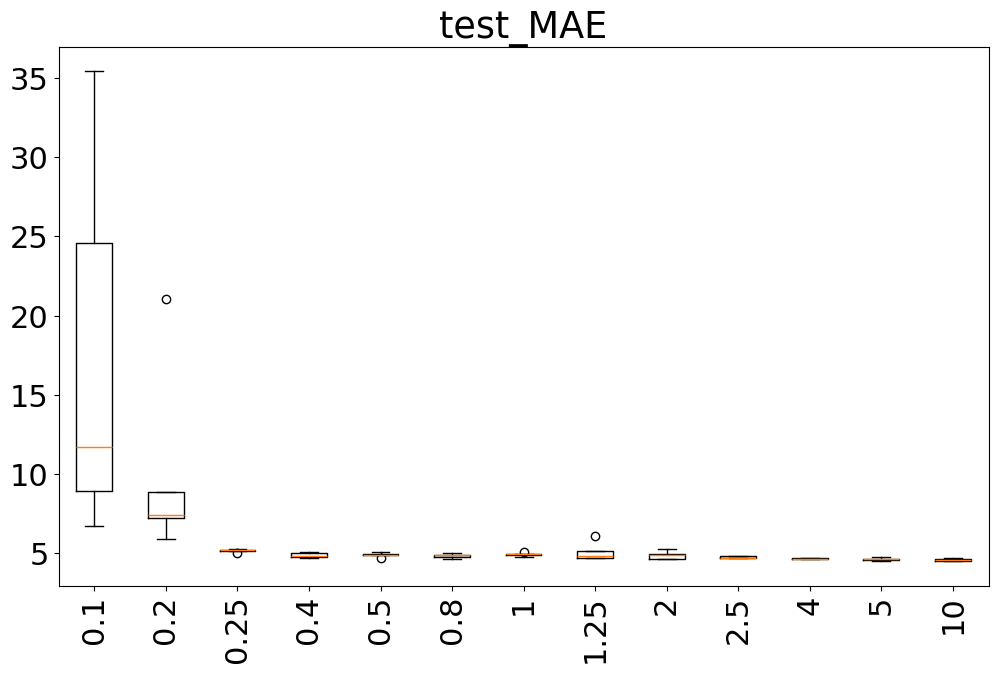

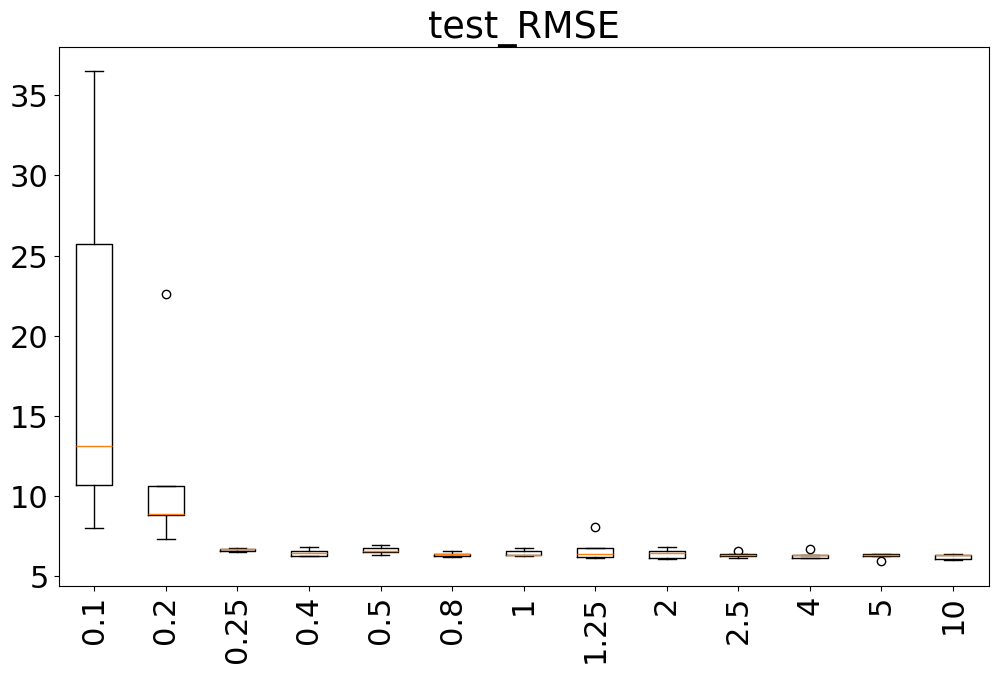

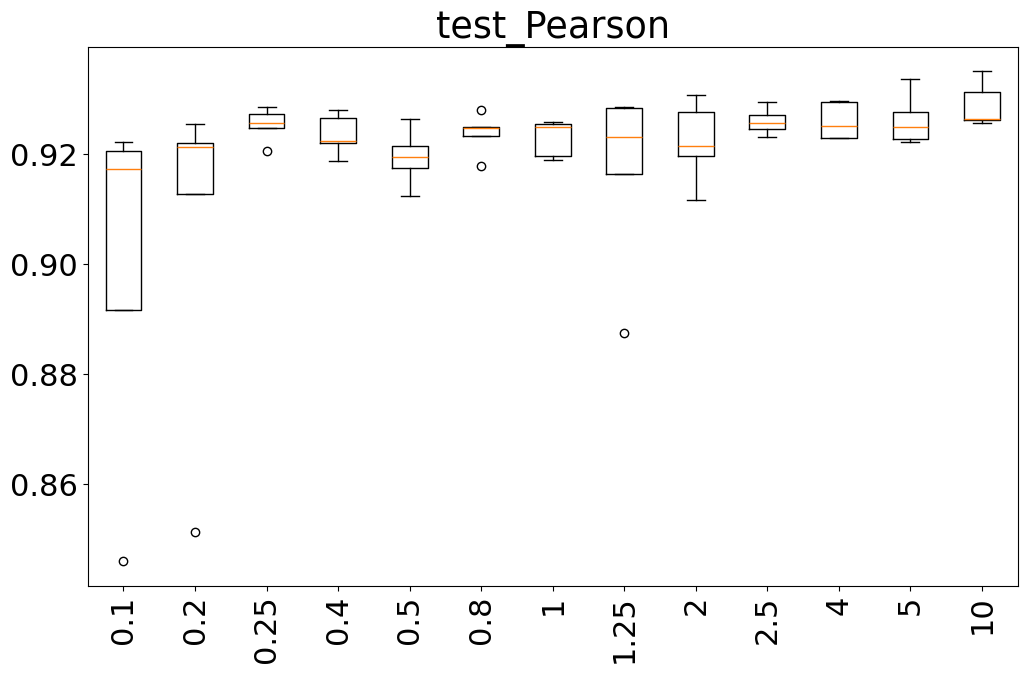

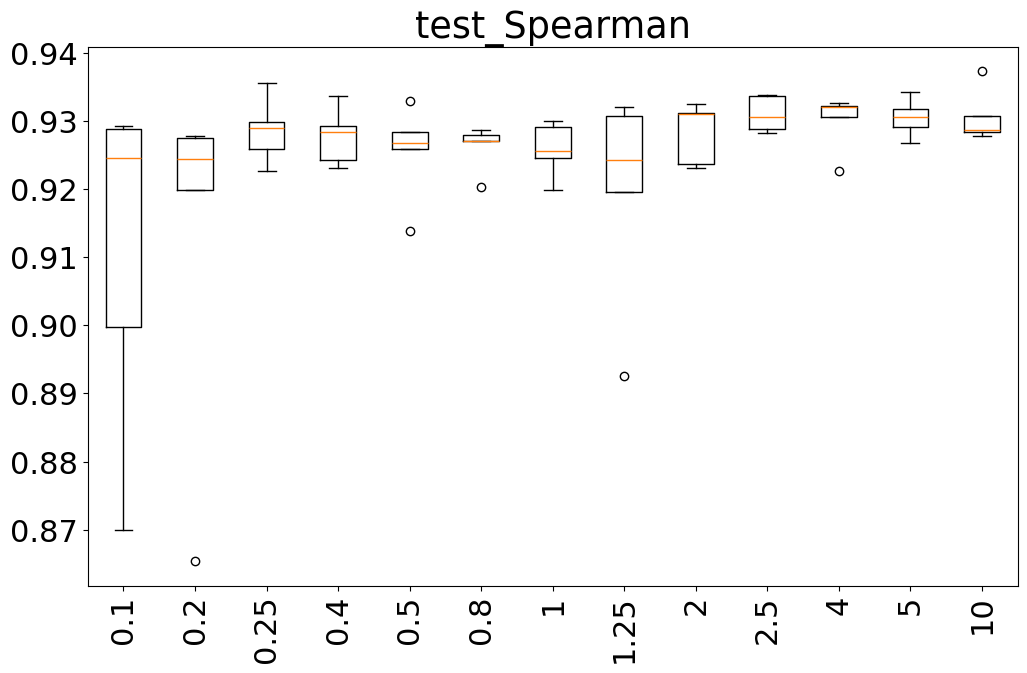

In [29]:
eval_metrics = ['test_MAE', 'test_RMSE', 'test_Pearson', 'test_Spearman']
evals = {}
epochs = GAR_res[decay][lr][metric].shape[-1]
params = {}
for metric in eval_metrics:
    evals[metric] = {}
    params[metric] = {}
    for para in range(13):
        paraname = paras[para]
        params[metric][paraname]={}
        evals[metric][paraname]={}
        evals[metric][paraname]['valid'] = np.ones(5)*metric_worst(metric)
        evals[metric][paraname]['test'] = np.ones(5)*metric_worst(metric)
        for replica in range(5):
            params[metric][paraname][replica]={}
            params[metric][paraname][replica]['decay']=-1
            params[metric][paraname][replica]['lr']=-1
            for decay in decays:
                lrs = GAR_res[decay].keys()
                for lr in lrs:
                    for i in range(epochs):
                        current = GAR_res[decay][lr][metric.replace('test','valid')][replica, para, i]
                        old = evals[metric][paraname]['valid'][replica]
                        if metric_isbetter(metric, old, current):
                            current_test = GAR_res[decay][lr][metric][replica, para, i]
                            evals[metric][paraname]['valid'][replica] = current
                            evals[metric][paraname]['test'][replica] = current_test
                            params[metric][paraname][replica]['decay'] = decay
                            params[metric][paraname][replica]['lr'] = lr
print(evals)
print(params)
print(paras)
boxvalues={}
for metric in eval_metrics:
#     print(metric)
    output = ''
    boxvalues[metric] = []
    for paraname in paras:
        values = evals[metric][paraname]['test']
        mean = np.around(np.mean(values), 3)
        std = np.around(np.std(values), 3)
        out = str(mean) + '(' + str(std) + ')\t'
        output += out
        boxvalues[metric].append(values)
    print(output)
    
for metric in eval_metrics:
    plt.figure(figsize=(12,7))
    plt.boxplot(boxvalues[metric])
    plt.title(metric)
    plt.xticks(np.arange(1,14), paras, rotation=90)
    fname = 'figures/'+dataname + '_' + metric + '_sensitivity.pdf'
    plt.savefig(fname,format='pdf')
    